In [1]:
from urllib.request import urlopen
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image

from datasets import load_dataset, load_dataset_builder
import torchvision.transforms.functional as TF
from torchvision import transforms

In [2]:
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = timm.create_model('levit_128s.fb_dist_in1k', pretrained=True)
    model.eval()
    model.fc = nn.Linear(2048, 101)
    model.head.linear = nn.Linear(384, 101)
    model.head_dist.linear = nn.Linear(384, 101)
    return model.to(device)

model = get_model().eval()
data_config = timm.data.resolve_model_data_config(model)
tfs = timm.data.create_transform(**data_config, is_training=False)
tfs_gray = transforms.Compose([transforms.Grayscale(3), tfs])

inp = tfs(img).unsqueeze(0)
output = model(tfs(img).unsqueeze(0).to(device))

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

pytorch_model.bin:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

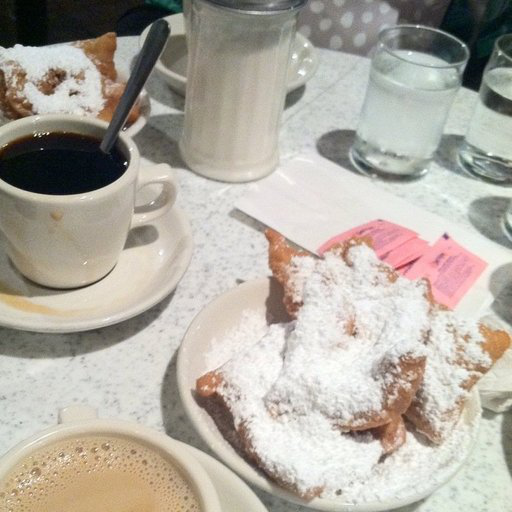

In [3]:
img

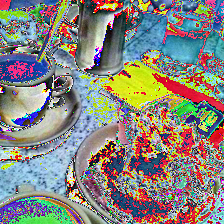

In [4]:
TF.to_pil_image(tfs(img))

In [5]:
tfs

Compose(
    Resize(size=248, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [6]:
output.shape

torch.Size([1, 101])

In [7]:
top5_probabilities, top5_class_indices

(tensor([[1.6403, 1.5067, 1.4477, 1.4129, 1.3793]], device='cuda:0',
        grad_fn=<TopkBackward0>),
 tensor([[88, 17, 94, 21, 10]], device='cuda:0'))

In [8]:
dsd = load_dataset('ethz/food101').shuffle()

Using custom data configuration ethz--food101-1798b89aa60e6037


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ethz___parquet/ethz--food101-1798b89aa60e6037/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
dsb = load_dataset_builder("ethz/food101")

Using custom data configuration ethz--food101-1798b89aa60e6037


In [10]:
dsb.info.description

''

In [11]:
dsb.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=101, names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lob

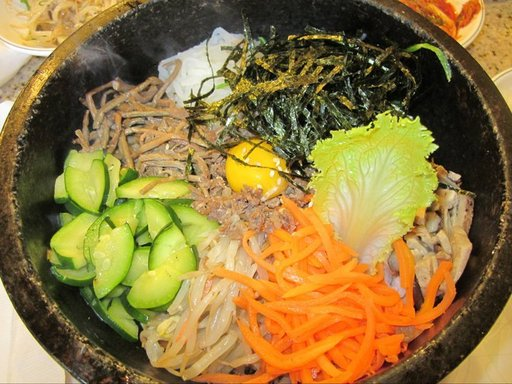

In [12]:
dsd['train'][0]['image']

In [13]:
x, y = dsb.info.features

In [14]:
def transform(b):
    b[x] = [TF.to_tensor(tfs(o)) for o in b[x]]
    return b

In [15]:
ds = dsd['train'].with_transform(transform)

Parameter 'transform'=<function transform at 0x7f78ec7f8430> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [16]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [17]:
@inplace
def transform(b):
    b[x] = [tfs(o).to(device) if TF.to_tensor(o).shape[0] == 3 else tfs(o.convert('RGB')).to(device) for o in b[x]]

In [18]:
ds = dsd['train'].with_transform(transform)
dsv = dsd['validation'].with_transform(transform)

In [19]:
dl_trn = DataLoader(ds, batch_size=200,)
dl_val = DataLoader(dsv, batch_size=50,)
model = get_model()
model.fc = nn.Linear(2048, dsb.info.features['label'].num_classes)

In [20]:
opt = torch.optim.AdamW(model.parameters(), 0.002)
epochs = 2
model.train()
for i, n_epoch in enumerate(range(epochs)):
    for batch_num, batch in enumerate(dl_trn):
        xb, yb = batch['image'], batch['label']
        output = model(xb)
        loss = F.cross_entropy(output, yb.to(device))
        loss.backward()
        print("train: " + str(loss.item()), end=', ')
        with torch.no_grad():
            opt.step()
            opt.zero_grad()
            
            model.eval()
            b = next(iter(dl_val))
            xb, yb = b['image'], b['label']
            preds = model(xb)
            loss_val = F.cross_entropy(preds, yb.to(device))
            print("val: " + str(loss_val.item()))
            model.train()

train: 4.636833667755127, val: 4.666658401489258
train: 4.610904693603516, val: 4.6552605628967285
train: 4.604149341583252, val: 4.640590667724609
train: 4.592924118041992, val: 4.651174068450928
train: 4.566067218780518, val: 4.665574073791504
train: 4.579392910003662, val: 4.676576614379883
train: 4.582516670227051, val: 4.6743693351745605
train: 4.523292064666748, val: 4.689914703369141
train: 4.53908634185791, val: 4.738614082336426
train: 4.465101718902588, val: 4.7733869552612305
train: 4.456274509429932, val: 4.799864292144775
train: 4.520806312561035, val: 4.799935817718506
train: 4.471739292144775, val: 4.78127908706665
train: 4.473788738250732, val: 4.721116542816162
train: 4.48538064956665, val: 5.119187831878662
train: 4.471253395080566, val: 5.321411609649658
train: 4.417121887207031, val: 5.742467880249023
train: 4.398154258728027, val: 6.148037910461426
train: 4.4372968673706055, val: 5.931325912475586
train: 4.351130485534668, val: 5.871229648590088
train: 4.3424482345

In [24]:
from PIL import Image
import requests
from io import BytesIO

url = 'https://static01.nyt.com/images/2021/02/17/dining/17tootired-grilled-cheese/17tootired-grilled-cheese-articleLarge.jpg?quality=75&auto=webp&disable=upscale'
def inference(url, model):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    model.eval()
    inp = tfs(img).unsqueeze(0).to(device)

    out_idx = model(inp).softmax(1).argmax()
    print(model(inp).shape)
    return dsb.info.features['label'].names[out_idx]

inference(url, model)

torch.Size([1, 101])


'grilled_cheese_sandwich'

In [25]:
dsb.info.features['label']

ClassLabel(num_classes=101, names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_

In [27]:
torch.save(model.state_dict(), "model.pt")

In [28]:
model = get_model()
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [29]:
inference(url, model)

torch.Size([1, 101])


'grilled_cheese_sandwich'

In [30]:
def accuracy(dl, model):
    losses = []
    i = 0
    correct = 0
    total = 0
    model.eval()
    for b in dl:
        with torch.no_grad():
            xb, yb = b['image'], b['label'].to(device)
            out = model(xb)
            loss = F.cross_entropy(out, yb)

            losses.append(loss)
            i+=1
            correct += (out.softmax(1).argmax(1) == yb).sum()
            total += xb.shape[0]
        
    return losses/i, correct/total

In [31]:
dl_val = DataLoader(dsv, batch_size=50,)

accuracy(dl_val, model)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [28]:
!nvidia-smi

Fri Sep 20 01:04:48 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   42C    P2    36W / 140W |   1753MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [27]:
model

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stages): Sequential(
    (

In [34]:
dsb.info.features['label'].names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster